In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# 1. Getting data

In [2]:
df_contract = pd.read_csv('datasets/contract.csv') # информация о договоре
df_internet = pd.read_csv('datasets/internet.csv') # информация об интернет-услугах
df_personal = pd.read_csv('datasets/personal.csv') #персональные данные клиента
df_phone = pd.read_csv('datasets/phone.csv')       #информация об услугах телефонии

Получено четыре датасета с описанием информации о договоре (df_contract), персональных данных клиента (df_personal), информацией о интернет-услугах (df_internet) и об услугах телефонии(df_phone).

In [3]:
def pre_check(df_list):
    descriptions_df = ['Информация о договоре', 'Информация об интернет-услугах', 'Персональные данные клиента',
                      'Информация об услугах телефонии']
    for index, df in enumerate(df_list):
        print('================================================================================================================')
        print()
        print(descriptions_df[index])
        print()
        display(df.head())
        df.info()
        print('Количество дубликатов: ', df.duplicated().sum())
        print('________________________________________________________________________________________________________________')

In [4]:
pre_check([df_contract, df_internet, df_personal, df_phone])


Информация о договоре



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
Количество дубликатов:  0
________________________________________________________________________________________________________________

Информация об интернет-услугах



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
Количество дубликатов:  0
________________________________________________________________________________________________________________

Персональные данные клиента



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
Количество дубликатов:  0
________________________________________________________________________________________________________________

Информация об услугах телефонии



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
Количество дубликатов:  0
________________________________________________________________________________________________________________


In [5]:
df_contract['target'] = df_contract['EndDate'].apply(lambda x: 0 if x=='No' else 1)
df_contract['EndDate'] = df_contract['EndDate'].apply(lambda x: '2020-02-01 00:00:00' if x=='No' else x)
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d %H:%M:%S')
df_contract =df_contract[df_contract['TotalCharges']!=' '].reset_index(drop=True)
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'])

В таблице df_contract:
* изменен тип данных поля начало и конца использования услуги на datetime.
* удалилен 11 записей в которых отсутствовали данные с общим количеством потраченных денег на услуги.
* изменен тип данных на float в поле TotalCharges.
* добавлено поле target, который описывает целевой признак задачи (ушел клиент или остался).

In [6]:
data = (df_personal
        .merge(df_contract, on='customerID', how='inner')
        .merge(df_internet, on='customerID', how='left')
        .merge(df_phone, on='customerID', how='left')
       )

# Список столбцов для заполнения значениями 'not_use'
columns_to_fill = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

data[columns_to_fill] = data[columns_to_fill].fillna('not_use')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   datetime64[ns]
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   object        
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  target            7032 non-null   int64         
 13  InternetService   7032 non-null   object        
 14  OnlineSecurity    7032 n

Получена общая таблица данных. Пропущенные данные соответствовали не использованию данной услуги (интернета, телефона), о чем была в соответствующих столбцах добавлено значение 'not_use'. 

# 2. Exploratory data analysis


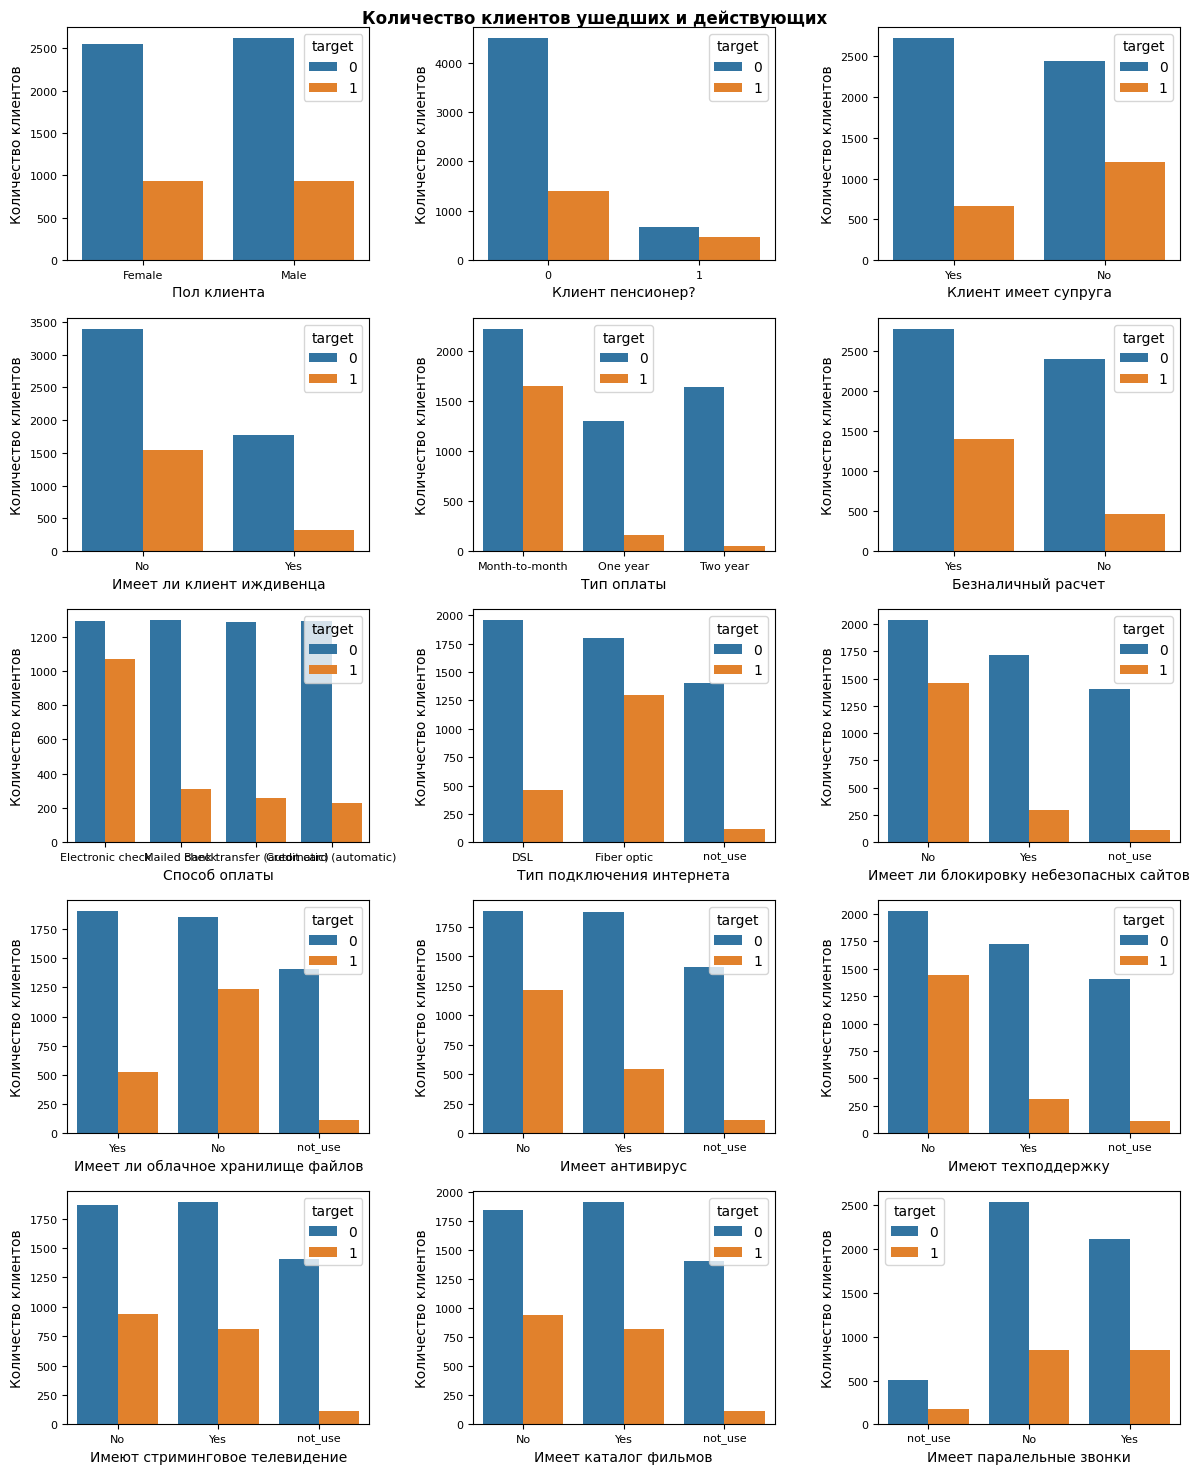

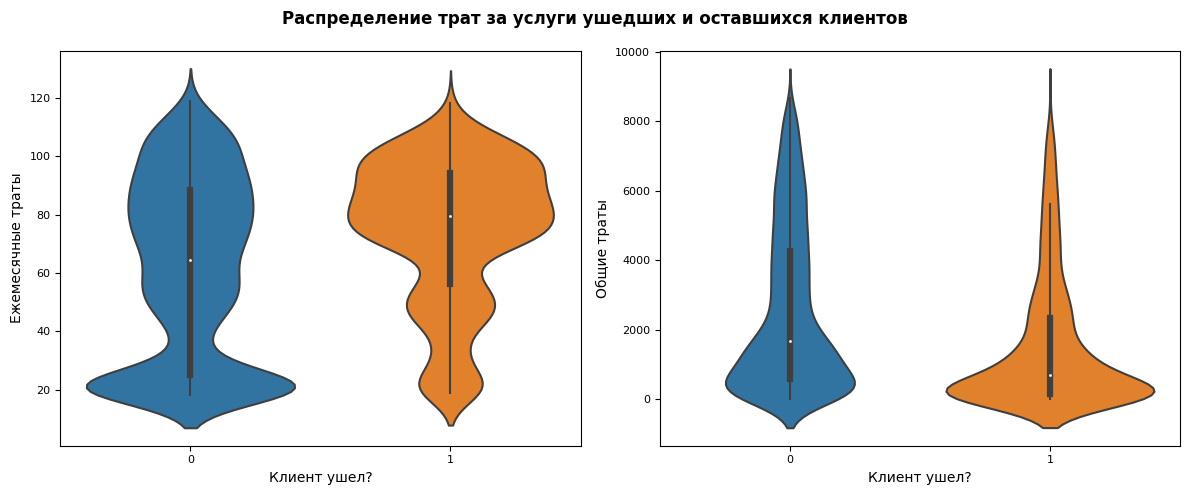

In [7]:
column_data = [
    ('gender', 'Пол клиента'),
    ('SeniorCitizen', 'Клиент пенсионер?'),
    ('Partner', 'Клиент имеет супруга'),
    ('Dependents', 'Имеет ли клиент иждивенца'),
    ('Type', 'Тип оплаты'),
    ('PaperlessBilling', 'Безналичный расчет'),
    ('PaymentMethod', 'Способ оплаты'),
    ('InternetService', 'Тип подключения интернета'),
    ('OnlineSecurity', 'Имеет ли блокировку небезопасных сайтов'),
    ('OnlineBackup', 'Имеет ли облачное хранилище файлов'),
    ('DeviceProtection', 'Имеет антивирус'),
    ('TechSupport', 'Имеют техподдержку'),
    ('StreamingTV', 'Имеют стриминговое телевидение'),
    ('StreamingMovies', 'Имеет каталог фильмов'),
    ('MultipleLines', 'Имеет паралельные звонки')
]

fig, axes = plt.subplots(5, 3, figsize=(12,15))
fig.suptitle('Количество клиентов ушедших и действующих', fontsize=12, fontweight='bold')

for i, (column, label) in enumerate(column_data):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    sns.countplot(x=column, data=data, hue='target', ax=ax)
    ax.set_xlabel(label)
    ax.set_ylabel('Количество клиентов')
    ax.tick_params(axis='both', labelsize=8)
    
plt.tight_layout()
plt.show()


y_values = ['MonthlyCharges', 'TotalCharges']
y_labels = ['Ежемесячные траты', 'Общие траты']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Распределение трат за услуги ушедших и оставшихся клиентов', fontsize=12, fontweight='bold')

for i, (y_value, y_label) in enumerate(zip(y_values, y_labels)):
    ax = axes[i]
    sns.violinplot(x='target', y=y_value, data=data, ax=ax)
    ax.set_xlabel('Клиент ушел?')
    ax.set_ylabel(y_label)
    ax.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

* Клиенты по гендеру разделены примерно поровну.
* Пенсионеров подключающих телеком всего 10%. Оставшихся пенсионеров чуть больше, чем ушедших.
* У оставшихся клиентах чуть больше тех кто имеет супруга. В то время как среди ушедших больше в 2 раза тех кто без супруга.
* У оставшихся клиентах имеющие иждивенца в 2 раза меньше чем неимеющие. Имеющие иждивенца намного чаще остаются чем уходят.
* Люди чаще выбирают платить раз в месяц, и при этом очень часто уходят. Люди выбирающие в качестве оплаты годовую или двухгодовую подписку почти не уходят.
* Людей выбравших безналичный расчет больше. При этом люди не выбравшие безналичный расчет реже уходят.
* Из тех кто остался способ оплаты распределен одинаково. В то время как среди ушедших чаще расплачиваются электронным чеком.
* Как видно люди чаще уходили использующие подключение через оптоволоконный кабель. Возможно надо обратить внимание на качество интернета при таком виде подключения.
* Среди всех ушедших намного чаще уходили люди не имеющие блокировку небезопасных сайтов. Возможно нужно уменьшить цену на эту услугу, либо сделать услугу постоянно входящую в тариф.
* Как видно оставшиеся клиенты разделены поровну. В то время как среди ушедших больше людей не имело этой услуги. Возможно у людей произошло потеря файлов, и они на эмоциях отказались от тарифа.
* Среди оставшихся услуга распределена поровну. В то время как среди ушедших больше людей не имело антивируса. Возможно во время использования интернета произошло заражение компьютера, произошло потеря важной информации. Люди стали винить кампанию и на эмоциях ушли.
* Среди ушедших много не имело техподдержку. Возможно надо ввести её бесплатно для всех клиентов.
* Данная услуга распределена одинаково как для ушедших так и для оставшихся. Возможно причина в том что сегодня немного людей смотрят телевидение. И поэтому люди не обращают внимание на эту услугу.
* Данная услуга распределена одинаково как для ушедших так и для оставшихся. Возможно причина в том что сегодня люди могут бесплатно скачать любой фильм бесплатно. И поэтому люди не обращают внимание на эту услугу.
* Люди оставшиеся чаще не имеют паралельных звонков. Возможно эту услугу выбирают те кому она действительно нужно.
* Как видно ушедшие клиенты тратили в среднем больше, чем оставшиеся. Возможно цена тарифа для них была слишком высока.
* Как видно ушедшие чуть меньше принесли общей выручке. Возможно если бы они остались распределение справа стало выше.

In [8]:
data['day'] = (data['EndDate'] - data['BeginDate']).dt.days
data = data.drop(['customerID', 'EndDate', 'BeginDate'], axis=1)

Добавлен новый признак количество дней использования тарифа. Удалены столбцы 'customerID', 'EndDate', 'BeginDate'.

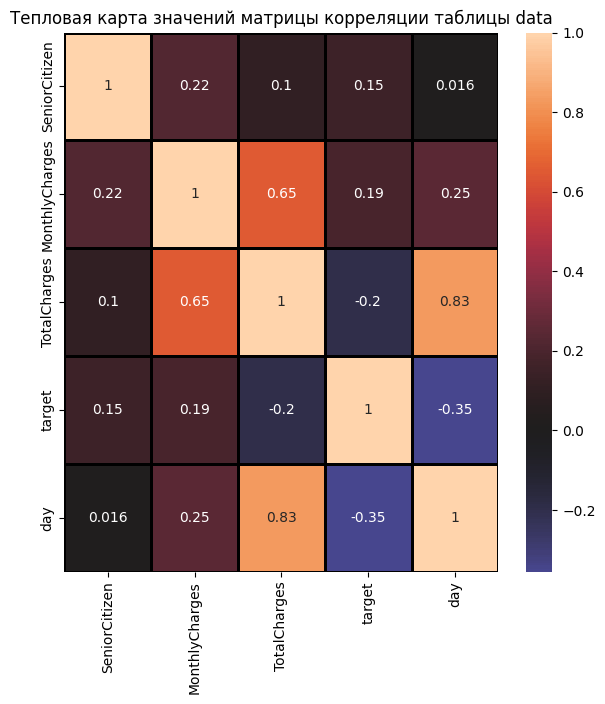

In [9]:
plt.figure(figsize=(7,7))
plt.title('Тепловая карта значений матрицы корреляции таблицы data')
sns.heatmap(data.corr(numeric_only=True), annot=True, center= 0, linewidths=1, linecolor='black')
plt.show()

In [10]:
data = data.drop(['TotalCharges'], axis=1)

Видна большая корреляция между днями использвания тарифа(day) и общими тратами на тариф (TotalCharges). Удалим столбец TotalCharges.

# 3. Model Selection

In [11]:
categorial = data.select_dtypes(include='object').columns
data_ohe = pd.get_dummies(data,drop_first=True,columns=categorial)

In [12]:
data_oe = data.copy()
encoder = OrdinalEncoder()
data_oe[categorial] = encoder.fit_transform(data_oe[categorial])

Преобразовали категориальные признаки в численные двумя методами: One-hot-encoding(data_ohe, будем использовать для обучения линейной модели) и OrdinalEncoding (data).

In [13]:
df_train1, df_test1 = train_test_split(data_ohe, test_size=0.25, random_state=12345)
features_train1 = df_train1.drop(['target'],axis=1)
target_train1 = df_train1['target']
features_test1 = df_test1.drop(['target'],axis=1)
target_test1 = df_test1['target']

In [14]:
df_train2, df_test2 = train_test_split(data_oe, test_size=0.25, random_state=12345)
features_train2 = df_train2.drop(['target'],axis=1)
target_train2 = df_train2['target']
features_test2 = df_test2.drop(['target'],axis=1)
target_test2 = df_test2['target']

In [15]:
df_train3, df_test3 = train_test_split(data, test_size=0.25, random_state=12345)
features_train3 = df_train3.drop(['target'],axis=1)
target_train3 = df_train3['target']
features_test3 = df_test3.drop(['target'],axis=1)
target_test3 = df_test3['target']

Разделили таблицы на обучающую и тестовую в соотношении 75:25 в зависимости от вида кодирования.

In [22]:
%%time
log_param = {
    'logreg__C':[0.1, 0.5, 1, 5, 10, 50, 100],
    'logreg__penalty':['l1','l2']
}
log_pipe = Pipeline(
    [('scaler', StandardScaler()), ('logreg', LogisticRegression(solver='liblinear',random_state=123456 ))]
)
log_grid = GridSearchCV(estimator=log_pipe,param_grid=log_param, cv=5, n_jobs=-1, verbose=True, scoring='roc_auc')
log_grid.fit(features_train1, target_train1)
log_grid.best_score_

Fitting 5 folds for each of 14 candidates, totalling 70 fits
CPU times: user 757 ms, sys: 404 ms, total: 1.16 s
Wall time: 5.77 s


0.8413916245965407

ROC-AUC линейной модели равен 0,84

In [23]:
%%time
rfc_params = {
    'max_depth': [2,4,7,10],
    'n_estimators': [50,100,200,500],
    'min_samples_leaf' : [2, 4, 8, 12],
    'min_samples_split': [2, 4, 8, 12]
}
rfc = RandomForestClassifier(random_state=123456, class_weight='balanced')
rfc_grid = GridSearchCV(rfc,rfc_params, cv=3, n_jobs=-1, verbose=True, scoring='roc_auc')
rfc_grid.fit(features_train2, target_train2)
rfc_grid.best_score_

Fitting 3 folds for each of 256 candidates, totalling 768 fits
CPU times: user 4.47 s, sys: 608 ms, total: 5.08 s
Wall time: 52.4 s


0.8555050354468959

ROC-AUC модели случайный лес равен 0,85

In [25]:
%%time
cat_params = {
    'learning_rate' : [0.03, 0.05, 0.1],
    'depth' : [2,4,6],
    'l2_leaf_reg' : [1,3,5]
}
cat = CatBoostClassifier(verbose=False, cat_features=list(categorial))
cat_grid = GridSearchCV(estimator=cat, param_grid=cat_params, scoring='roc_auc', cv=3)
cat_grid.fit(features_train3, target_train3 )
cat_grid.best_score_

CPU times: user 50min 55s, sys: 16min 9s, total: 1h 7min 4s
Wall time: 8min 4s


0.9171765608781112

ROC-AUC модели градиентного бустинга catboost равен 0,92

<b>Вывод наилучшей моделью является градиентный бустинг catboost</b>

In [30]:
cat_grid.best_params_

{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

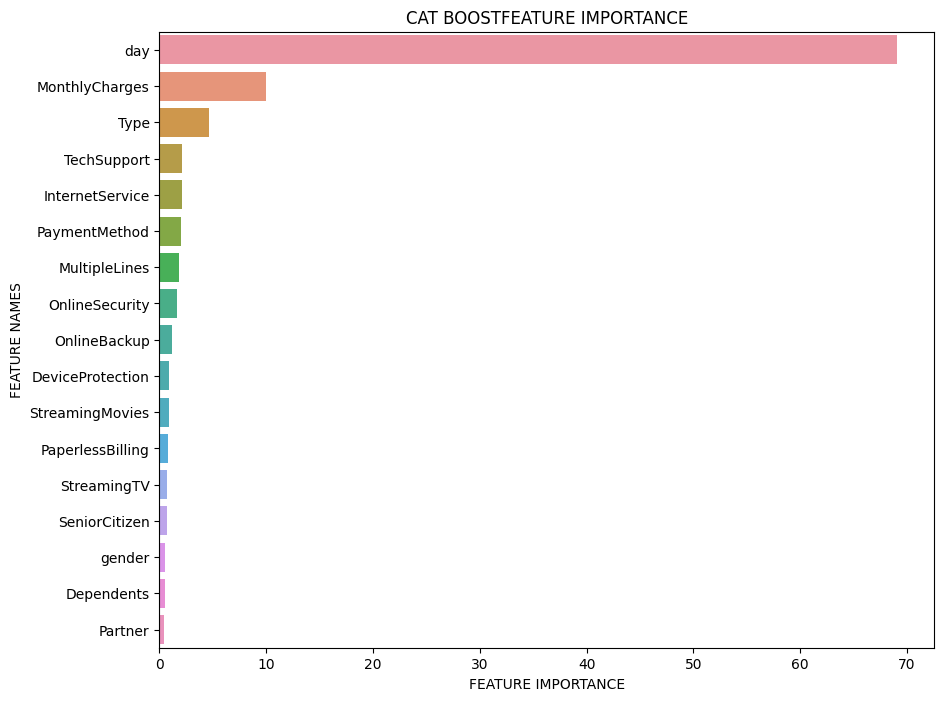

In [31]:
cat_model = CatBoostClassifier(verbose=False, learning_rate=0.1, depth=4, l2_leaf_reg=1 ,random_seed=123456, cat_features=list(categorial))
cat_model.fit(features_train3, target_train3)


def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data = {'feature_names':feature_names, 'feature_importance':feature_importance}
    df = pd.DataFrame(data)
    df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=df['feature_importance'], y=df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

plot_feature_importance(cat_model.get_feature_importance(), features_train3.columns,'CAT BOOST')

Как видно по графикам наибольшую важность имеет признак day, MonthlyCharges, Type. Остальные очень малы. Их можно удалить.

In [26]:
features_train_imortance=features_train3[['day','MonthlyCharges', 'Type']]
features_test_imortance=features_test3[['day','MonthlyCharges', 'Type']]

# 4. Testing the model

In [17]:
cat_model = CatBoostClassifier(verbose=False, learning_rate=0.1, depth=4, l2_leaf_reg=1 ,random_seed=123456, cat_features=['Type'])
cat_model.fit(features_train_imortance, target_train3)
propabilities = cat_model.predict_proba(features_test_imortance)[:,1]
tre = 0.29
pred_valid = propabilities > tre
roc = roc_auc_score(target_test3, pred_valid)
accuracy= accuracy_score(target_test3, pred_valid)
print('ROC-AUC модели градиентного бустинга равна: ',roc)
print('Доля правильных ответов модели градиентного бустинга равна:',accuracy)

ROC-AUC модели градиентного бустинга равна:  0.8526532445176258
Доля правильных ответов модели градиентного бустинга равна: 0.8754266211604096


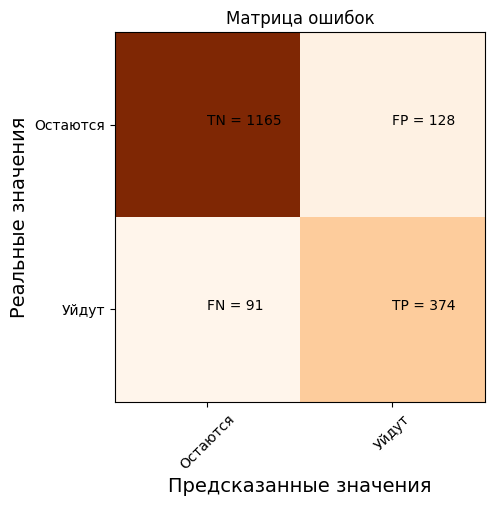

In [40]:
plt.clf()
cm = confusion_matrix(target_test3, pred_valid)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
classNames = ['Остаются','Уйдут']
plt.title('Матрица ошибок')

plt.ylabel('Реальные значения', fontsize=14)
plt.xlabel('Предсказанные значения', fontsize=14)

tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

Построена матрица ошибок окончательной модели.

<b>Вывод: </b> Заметно небольшое переобучение модели. Модель готова к выпуску в продакшн.

In [41]:
model_data = {
    'model': cat_model,
    }

In [42]:
pickle.dump(model_data ,open('api/model_store/cat_model.pkl', 'wb'))